# Crecimiento de los salarios y el proceso de inflación

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [3]:
filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'
df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')

In [5]:
print(df.shape)  # (123, 8)

(123, 8)


In [6]:
df.tail()

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1988-07-01,4042.7,3971.9,179.6,131.5,124.9,106.2,123.5,92.8
1988-10-01,4069.4,3995.8,181.3,133.3,126.2,107.3,124.9,92.9
1989-01-01,4106.8,4019.9,184.1,134.8,127.7,109.5,126.6,94.0
1989-04-01,4132.5,4044.1,186.1,134.8,129.3,111.1,129.0,100.6
1989-07-01,4162.9,4068.4,187.4,137.2,130.2,109.8,129.9,98.2


In [7]:
# rgnp : GNP real.
# pgnp : Potencial GNP real.
# ulc : Costo de mano de obra unitaria.
# gdfco : Deflactor de peso fijo para gastos de consumo personal excluyendo alimentos y energía.
# gdf : Deflactor GNP de peso fijo.
# gdfim : Deflador de importación de peso fijo.
# gdfcf : Deflactor de peso fijo para alimentos en gastos de consumo personal.
# gdfce : Deflactor de peso fijo para energía en gastos de consumo personal.

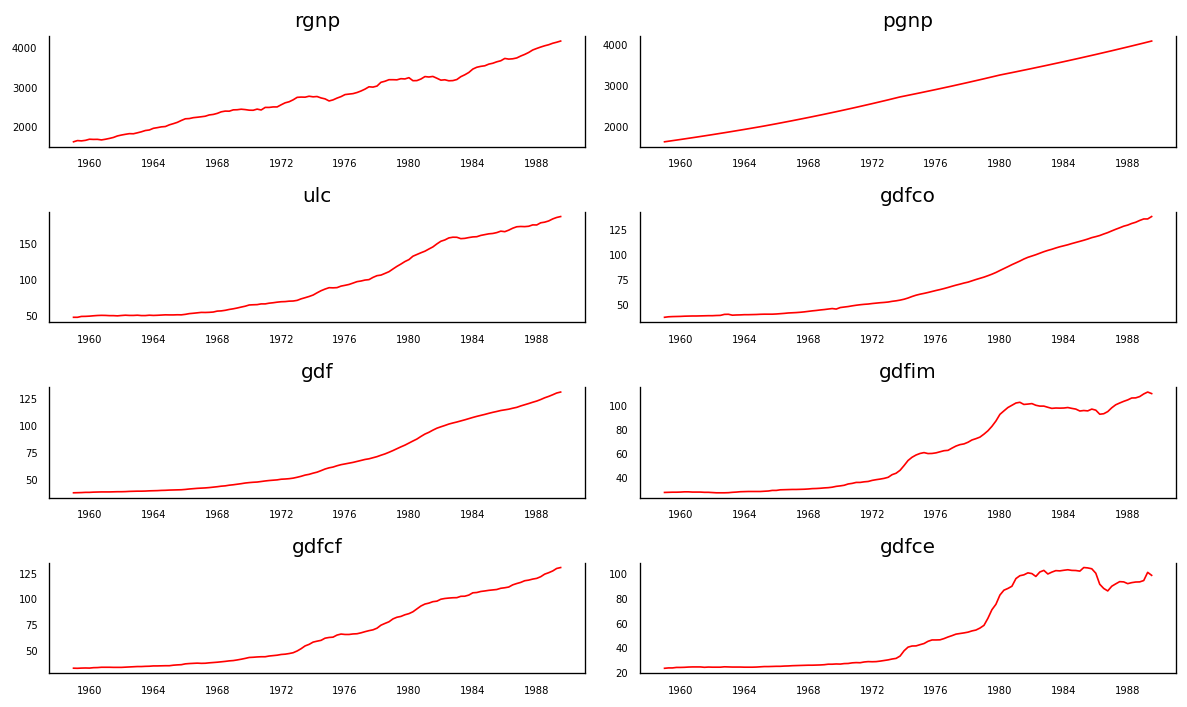

In [8]:
# GRÁFICO

fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

> # PRUEBA DE CAUSALIDAD

Prasa este caso se usa la prueba de Granger, la cual pone a prueba la hipótesis nula de que los coeficientes de los valores pasados son cero. Es decir, los valores pasados de la serie [X] no implica causalidad en la otra serie [Y]. 

De hecho, para dicha pureba si el p-value < 0.05 rechazamos la hipótesis nula.

El código que se muestra almacena los p-value de cada una de lass combinaciones en la matríz de salida.

In [9]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.
    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [10]:
grangers_causation_matrix(df, variables = df.columns) 

,rgnp_x,pgnp_x,ulc_x,gdfco_x,gdf_x,gdfim_x,gdfcf_x,gdfce_x
rgnp_y,1.0000,0.0003,0.0001,0.0212,0.0014,0.0620,0.0001,0.0071
pgnp_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ulc_y,0.0000,0.0000,1.0000,0.0002,0.0000,0.0000,0.0000,0.0041
gdfco_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
gdf_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
gdfim_y,0.0011,0.0067,0.0014,0.0083,0.0011,1.0000,0.0004,0.0000
gdfcf_y,0.0000,0.0000,0.0008,0.0008,0.0000,0.0038,1.0000,0.0009
gdfce_y,0.0025,0.0485,0.0000,0.0002,0.0000,0.0000,0.0000,1.0000


Las columnas representan la serie predictoria [X] mientras que las filas son las respuestas [Y]. Por lo que al interpretar el resultado de la prueba podemos observar que para la mayoria de los casos estos resultasos son menores a 0.05, es decir, p-value < 0.005 entonces se rechaza la hipótesis nula.

Al observar los p_value de la tabla anterior, puede identificar que todas las variables del sistema se están causando indistintamente entre sí.

Sificiente para usar los odelos VAR para pronósticar.

> # COINTEGRACIÓN

La prueba de cointegración ayuda a establecer la presencia de una conexión estadísticamente significativa entre dos o más series temporales.

cuando se tienen dos o más series temporales, y existe una combinación lineal de ellas que tiene un orden de integración (d) menor que el de la serie individual, entonces se dice que la colección de series está cointegrada.

In [11]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)


In [12]:
cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
rgnp   ::  248.0     > 143.6691  =>   True
pgnp   ::  183.12    > 111.7797  =>   True
ulc    ::  130.01    > 83.9383   =>   True
gdfco  ::  85.28     > 60.0627   =>   True
gdf    ::  55.05     > 40.1749   =>   True
gdfim  ::  31.59     > 24.2761   =>   True
gdfcf  ::  14.06     > 12.3212   =>   True
gdfce  ::  0.45      > 4.1296    =>   False


> DATOS DE ENTRENAMIENTO

 El modelo VAR se instalará en df_train y luego se utilizará para pronosticar los próximos 4 observaciones. Estas previsiones se compararán con las reales presentes en datos de prueba.

In [13]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

In [14]:
# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)


(119, 8)
(4, 8)


> # ESTACIONALIDAD

Una serie temporal estacionaria es una cuyas características como la media y la varianza no cambian con el tiempo.

Para el caso de esta serie, se usa la prueba aumentada de Dickey-Fuller (ADF). Si la prueba no es estacionaria es necesario diferir la serie una vez y repetir la prueba hasta que esta sea estacionaria.

In [18]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

        # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [19]:
 # ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')       


    Augmented Dickey-Fuller Test on "rgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.5428
 No. Lags Chosen       = 2
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.9861. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "pgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.1556
 No. Lags Chosen       = 1
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.9957. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ulc" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. N

La prueba ADF confirma que ninguna de las series temporales está estacionaria, entonces es necesario diferenciar hasta aque la serie se vuelva estacionaria.

In [20]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [21]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "rgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.3448
 No. Lags Chosen       = 1
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8282
 No. Lags Chosen       = 0
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.3666. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ulc" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signifi

Después de la primera diferencia, todavía no está estacionario, de hecho, su valor crítico está entre el 5% y el 10% de nivel de significancia. Entonces se tiene dos opciones, continuar con la primer serie diferenciada o diferenciar la serie una vez más.

In [22]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [23]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "rgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.0123
 No. Lags Chosen       = 2
 Critical value 1%     = -3.489
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.9813
 No. Lags Chosen       = 0
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ulc" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 T

Finalmente, todas las series son estacionarias.

> # ENCONTRAR EL ORDEN DEL MODELO VAR

Para seleccionar el orden correcto del modelo VAR, se ajusta iterativamente los órdenes crecientes de modelo VAR y se selecciona el orden que da un modelo con menos AIC.

In [24]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -1.3679402315450695
BIC :  0.3411847146588807
FPE :  0.255268251734719
HQIC:  -0.6741331335699585 

Lag Order = 2
AIC :  -1.6212373944478258
BIC :  1.624943209529583
FPE :  0.20113494371371354
HQIC:  -0.3036288826795941 

Lag Order = 3
AIC :  -1.7658008387012836
BIC :  3.034547316376779
FPE :  0.18125103746164284
HQIC:  0.18239143783962852 

Lag Order = 4
AIC :  -2.0007351644703144
BIC :  4.371215137654091
FPE :  0.15556966521481155
HQIC:  0.5849359332771105 

Lag Order = 5
AIC :  -1.961953560836398
BIC :  5.999364562242093
FPE :  0.1869279438911484
HQIC:  1.2682063311783303 

Lag Order = 6
AIC :  -2.330338652482909
BIC :  7.238452689088577
FPE :  0.16380374017443608
HQIC:  1.5514371669548037 

Lag Order = 7
AIC :  -2.5923313523471325
BIC :  8.602387254937792
FPE :  0.18238685837154078
HQIC:  1.9483069621146516 

Lag Order = 8
AIC :  -3.317261976458205
BIC :  9.52219581032303
FPE :  0.15573163248209088
HQIC:  1.8896071386220985 

Lag Order = 9
AIC :  -4.80476312595

C:\Users\Seguros\Desktop\ANACONDA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


En los resultados anteriores, el AIC en el retraso 4 es el más bajo, luego en el retraso 5 aumenta para finalmente disminuir en los demás retrasos.

> ELECCIÓN DEL ORDEN(P) EN LOS MODELOS VAR

In [26]:
# AUTO-FIT

x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-0.07898,0.1232,0.9241,0.002961
1,-0.5721,1.248,0.5662,0.1653
2,-0.8256,2.612,0.4482,0.5674
3,-1.007,4.048,0.3937,1.042
4,-1.255,5.418,0.3399,1.449
5,-1.230,7.060,0.4147,2.129
6,-1.739,8.169,0.3286,2.276
7,-2.142,9.384,0.3340,2.528
8,-2.964,10.18,0.2744,2.362
9,-4.562,10.20,0.1413,1.420


Dado que el AIC calculado explícitamente es el más bajo en el retraso 4, entonces se toma p=4.

In [28]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 01, May, 2021
Time:                     18:13:43
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    4.37122
Nobs:                     113.000    HQIC:                  0.584936
Log likelihood:          -905.679    FPE:                   0.155570
AIC:                     -2.00074    Det(Omega_mle):       0.0200322
--------------------------------------------------------------------
Results for equation rgnp
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            2.430021         2.677505            0.908           0.364
L1.rgnp         -0.750066         0.159023           -4.717           0.000
L1.pgnp         -0.095621         4.938865           -0.019           0.985
L1.ul

> COMPROBAR CORRELACIÓN EN SERIE RESTANTE

La correlación serial de residuos se utiliza para comprobar si hay algún patrón sobrante en los residuos (errores). Si queda alguna correlación en los residuos, entonces,hay algún patrón en la serie temporal que todavía queda por explicar por elmodelo. En ese caso, el curso de acción típico es aumentar el ordendel modelo o inducir más predictores en el sistema o buscar un algoritmo para modelar la serie temporal.

Una forma común de comprobar la correlación serial de errores se puede medir usando la estadística del Durbin Watson.

El valor de esta estadística puede variar entre 0 y 4. Cuanto más cerca esté del valor  2, entonces no hay una correlación serial significativa. Cuanto más cerca de 0, hay un correlación serial positiva, y cuanto más cerca esté de 4 implica serie negativa correlación.

In [29]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

In [30]:
for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

rgnp : 2.09
pgnp : 2.02
ulc : 2.17
gdfco : 2.05
gdf : 2.25
gdfim : 1.99
gdfcf : 2.2
gdfce : 2.17


> # FORECASTING

In [31]:
# Get the lag order (we already know this)
lag_order = model_fitted.k_ar
print(lag_order)

4


In [32]:
# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input


array([[ 13.5,   0.1,   1.4,   0.1,   0.1,  -0.1,   0.4,  -2. ],
       [-23.6,   0.2,  -2. ,  -0.5,  -0.1,  -0.2,  -0.3,  -1.2],
       [ -3.3,   0.1,   3.1,   0.5,   0.3,   0.4,   0.9,   2.2],
       [ -3.9,   0.2,  -2.1,  -0.4,   0.2,  -1.5,   0.9,  -0.3]])

In [33]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs) # nobs defined at top of program
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,rgnp_2d,pgnp_2d,ulc_2d,gdfco_2d,gdf_2d,gdfim_2d,gdfcf_2d,gdfce_2d
date,,,,,,,,
1988-10-01,48.322456,1.250774,0.595993,0.265657,-0.104146,0.304119,-0.917227,-0.113061
1989-01-01,-34.962286,-0.387966,-0.329877,-0.042217,0.164633,1.357223,0.618163,3.029975
1989-04-01,20.392680,0.291298,0.390812,-0.134488,-0.486073,-0.149551,-1.238234,-2.345223
1989-07-01,-37.416599,-0.280943,0.367912,0.102797,0.333371,-0.502103,0.469468,0.517424


Las previsiones se generan, pero está en la escala de los datos de entrenamiento utilizados por el modelo. Por lo tanto, para llevarlo de nuevo a su escala original, es necesario de diferenciar tantas veces que había diferenciado los datos de entrada originales.

In [34]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc


In [35]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['rgnp_forecast', 'pgnp_forecast', 'ulc_forecast', 'gdfco_forecast',
                   'gdf_forecast', 'gdfim_forecast', 'gdfcf_forecast', 'gdfce_forecast']]


,rgnp_forecast,pgnp_forecast,ulc_forecast,gdfco_forecast,gdf_forecast,gdfim_forecast,gdfcf_forecast,gdfce_forecast
date,,,,,,,,
1988-10-01,4123.022456,3996.950774,181.095993,132.965657,126.395854,106.604119,125.082773,93.186939
1989-01-01,4168.382626,4021.613582,182.262108,134.389097,128.056341,108.365461,127.283708,96.603854
1989-04-01,4234.135476,4046.567687,183.819036,135.678050,129.230756,109.977252,128.246409,97.675545
1989-07-01,4262.471728,4071.240850,185.743875,137.069799,130.738542,111.086940,129.678579,99.264661


> # GRÁFICO PORNÓSTICO

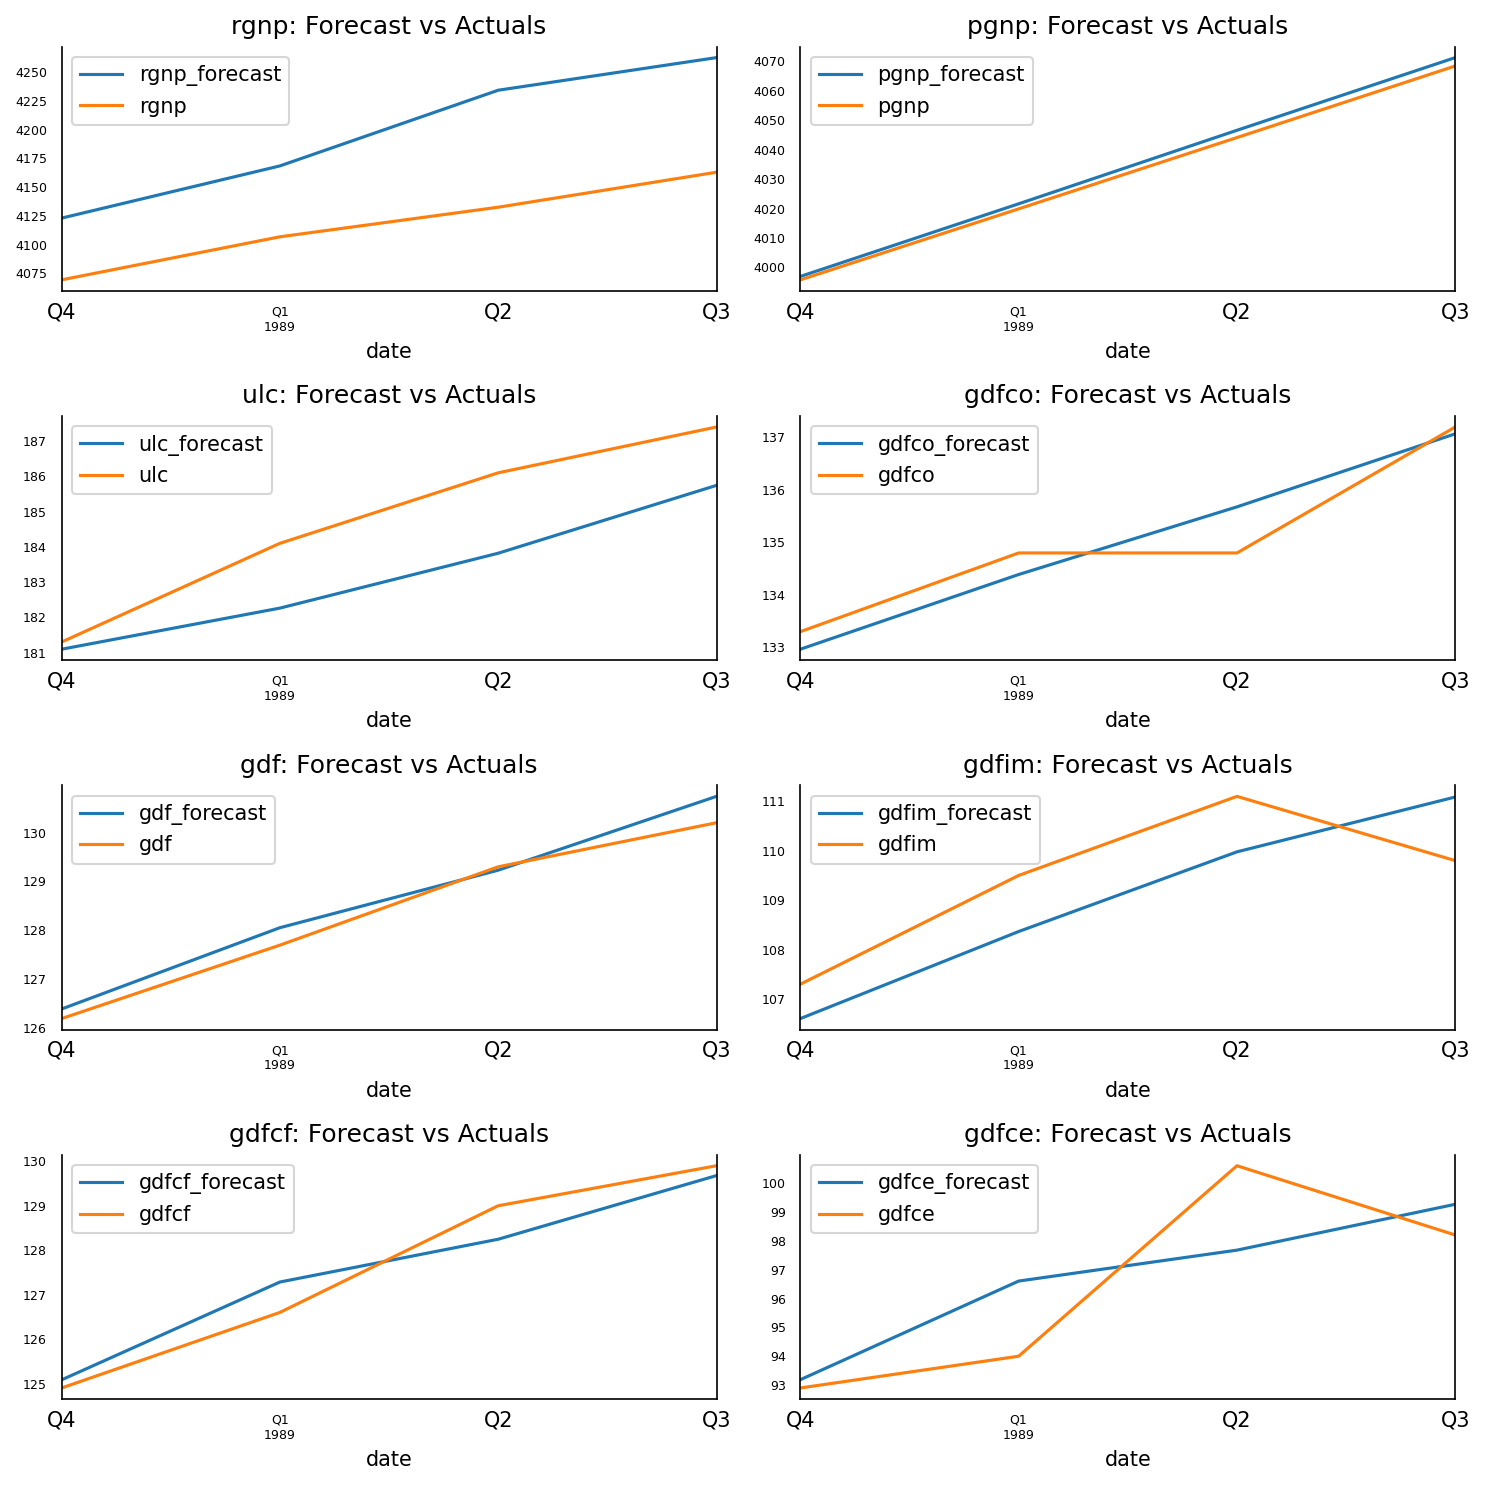

In [37]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();